# Import libraries

In [14]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

%matplotlib inline

## Models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# Feature selection
from sklearn.feature_selection import SelectFromModel

## Model evaluators
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve

# Import and clean data

In [15]:
df = pd.read_csv("/content/diabetes.csv") 

In [16]:
df.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
2,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
3,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
4,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive


In [17]:
df['class'] = df['class'] ==  'Positive'

In [18]:
df['class'].value_counts()

True     320
False    200
Name: class, dtype: int64

In [19]:
df['Gender'] = df['Gender'] ==  'Male'

In [20]:
yesorno = {'Yes': True, 'No': False}

In [21]:
df = df.replace(yesorno)

In [22]:
df.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,True,False,True,False,True,False,False,False,True,False,True,False,True,True,True,True
1,58,True,False,False,False,True,False,False,True,False,False,False,True,False,True,False,True
2,41,True,True,False,False,True,True,False,False,True,False,True,False,True,True,False,True
3,45,True,False,False,True,True,True,True,False,True,False,True,False,False,False,False,True
4,60,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True


In [23]:
df.to_csv('/content/diabetes_clean.csv')

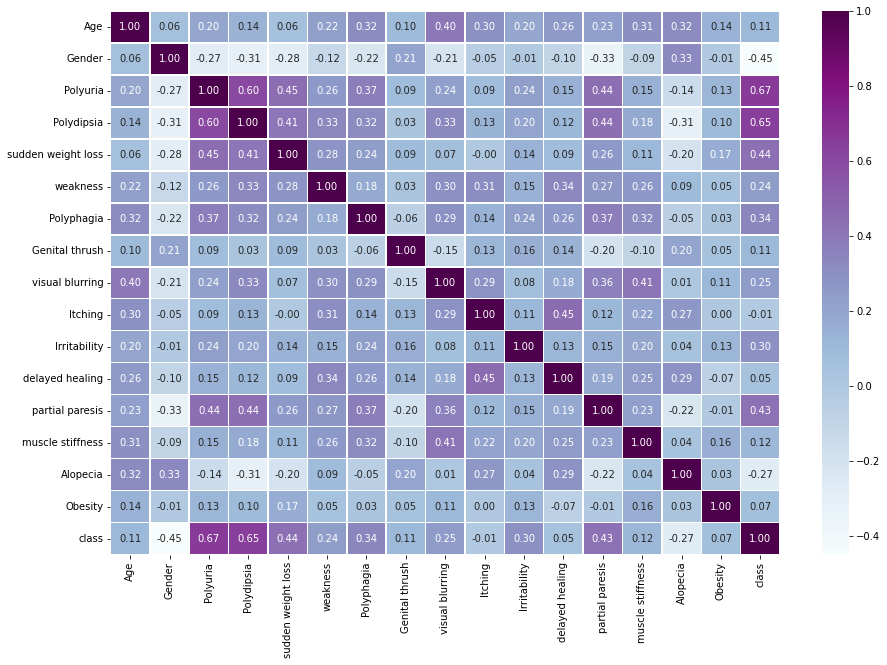

In [24]:
# Confusion Matrix
corr_matrix = df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, 
            annot=True, 
            linewidths=0.5, 
            fmt= ".2f", 
            cmap="BuPu");

In [25]:
# Everything except target variable
X = df.drop("class", axis=1)

# Target variable
y = df['class'].values

# Prune features using decision tree

In [26]:
#Prune features using decision tree
clf = DecisionTreeClassifier()
clf.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [27]:
pickle.dump(clf, open('decision_tree.pkl', 'wb'))

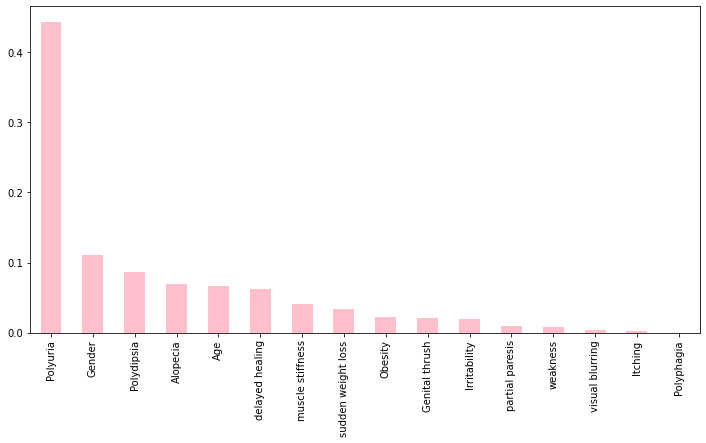

In [28]:
# Use the fitted model to generate a graph of feature importance
pd.Series(clf.feature_importances_, index=df.columns[:len(df.columns)-1]).sort_values(ascending=False).plot.bar(color='pink', figsize=(12, 6))

In [29]:
from sklearn.feature_selection import RFECV

clf = DecisionTreeClassifier()
trans = RFECV(clf)
X_trans = trans.fit_transform(X, y)
columns_retained_RFECV = df.iloc[:, :-1].columns[trans.get_support()].values
columns_retained_RFECV

array(['Age', 'Gender', 'Polyuria', 'Polydipsia', 'sudden weight loss',
       'Genital thrush', 'visual blurring', 'Irritability',
       'delayed healing', 'Alopecia', 'Obesity'], dtype=object)

In [30]:
X_trans

array([[40, True, False, ..., True, True, True],
       [58, True, False, ..., False, True, False],
       [41, True, True, ..., True, True, False],
       ...,
       [58, False, True, ..., False, False, True],
       [32, False, False, ..., True, True, False],
       [42, True, False, ..., False, False, False]], dtype=object)

# Split data into training / test sets

In [31]:
# Random seed for reproducibility
np.random.seed(42)

# Split into train & test set
X_train, X_test, y_train, y_test = train_test_split(X_trans, # independent variables 
                                                    y, # dependent variable
                                                    test_size = 0.2) # percentage of data to use for test set

# Compare 3 potential models

In [32]:
# Put models in a dictionary
models = {"KNN": KNeighborsClassifier(),
          "Logistic Regression": LogisticRegression(max_iter=1000), 
          "Random Forest": RandomForestClassifier()}

In [33]:
# define method to fit multiple models
def multi_fit(models, X_train, y_train):
    # Random seed for reproducible results
    np.random.seed(42)
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)

In [34]:
# fit all 3 models
model_metrics = multi_fit(models=models,
                          X_train=X_train,
                          y_train=y_train)

In [35]:
# Create function to generate cross validated metrics for multiple models
def cross_validated_metrics(models, X,  y):
    
    # Random seed for reproducible results
    np.random.seed(42)
    # Make a list to keep model scores totals
    model_scores = {}
    # Loop through models
    for name, model in models.items():
        # make a list to hold collected scores for each model
        collected_scores = {}
        # gather mean of cross validated score for a variety of metrics
        for metric in ['accuracy', 'precision', 'recall']:
            collected_scores[metric] = np.mean(cross_val_score(model,
                                                               X,
                                                               y,
                                                               cv=5, # 5-fold cross-validation
                                                               scoring=metric)) # loop through scoring methods
        model_scores[name] = collected_scores
    return model_scores

In [36]:
model_metrics = cross_validated_metrics(models=models,
                                       X=X_trans,
                                       y=y)
model_metrics

{'KNN': {'accuracy': 0.875, 'precision': 0.9531033293082629, 'recall': 0.8375},
 'Logistic Regression': {'accuracy': 0.9134615384615385,
  'precision': 0.9288488618244284,
  'recall': 0.934375},
 'Random Forest': {'accuracy': 0.9692307692307693,
  'precision': 0.9674275680421422,
  'recall': 0.9875}}

#### Seperate. using random forest test to verify results are the same

In [37]:
# Fit model and get baseline score
np.random.seed(42)
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# cross validated accuracy score for random forest
cv_acc_rf = np.mean(cross_val_score(rf,
                                       X_trans,
                                       y,
                                       cv=5, # 5-fold cross-validation
                                       scoring="accuracy")) # precision as scoring
cv_acc_rf

0.9673076923076923

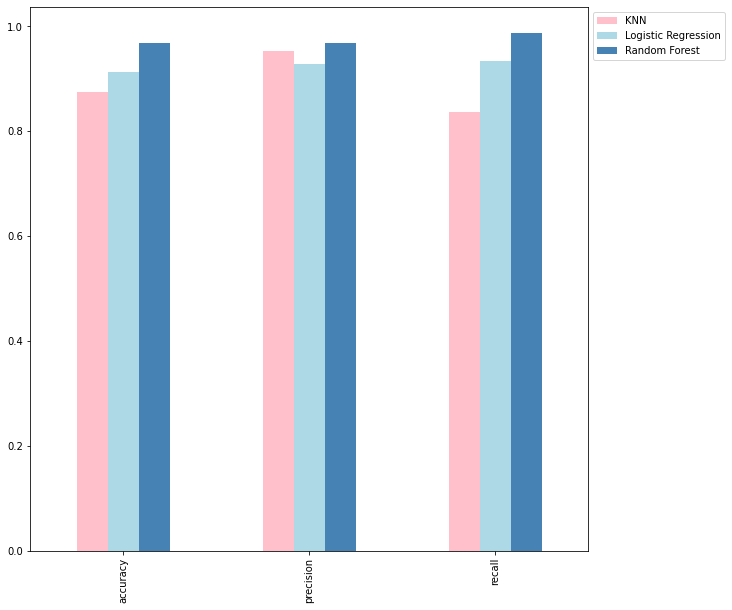

In [38]:
compare_metrics = pd.DataFrame(model_metrics)

compare_metrics.plot.bar(color=['Pink','lightblue','steelblue'], figsize=(10, 10)).legend(bbox_to_anchor=(1,1));

In [ ]:
df_new = pd.read_csv("data/diabetes_clean_pruned.csv") 

In [ ]:
df_new.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,Genital thrush,Irritability,delayed healing,muscle stiffness,Alopecia,Obesity,class
0,40,True,False,True,False,False,False,True,True,True,True,True
1,58,True,False,False,False,False,False,False,False,True,False,True
2,41,True,True,False,False,False,False,True,True,True,False,True
3,45,True,False,False,True,True,False,True,False,False,False,True
4,60,True,True,True,True,False,True,True,True,True,True,True


# Attempt to tune hyperparameters
First try for logistic regression, then for randomforest

### Attempt to tune hyperparameters on random forest

In [ ]:
# Fit model and get baseline score
rf = RandomForestClassifier()
np.random.seed(42)
rf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(), 
                               param_distributions = random_grid, 
                               n_iter = 1, cv = 3, 
                               verbose=2, 
                               random_state=42, 
                               n_jobs = -1)
# Fit the random search model
# rf_random.fit(X_train, y_train)

In [ ]:
# best = rf_random.best_params_
best

In [ ]:
rf_random.score(X_test, y_test)

In [ ]:
newmodels = {"Logistic Regression": models["Logistic Regression"],
             "Random Forest": models["Random Forest"], 
            "RS trained RF" : rf_random}

In [ ]:
model_metrics = cross_validated_metrics(models=newmodels,
                                       X=X_trans,
                                       y=y)
model_metrics

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.0s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    1.1s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.7s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.6s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    0.5s finished


{'Logistic Regression': {'accuracy': 0.925,
  'precision': 0.9506339730312602,
  'recall': 0.928125},
 'Random Forest': {'accuracy': 0.975,
  'precision': 0.9764548494983277,
  'recall': 0.98125},
 'RS trained RF': {'accuracy': 0.9538461538461537,
  'precision': 0.9606617647058823,
  'recall': 0.96875}}

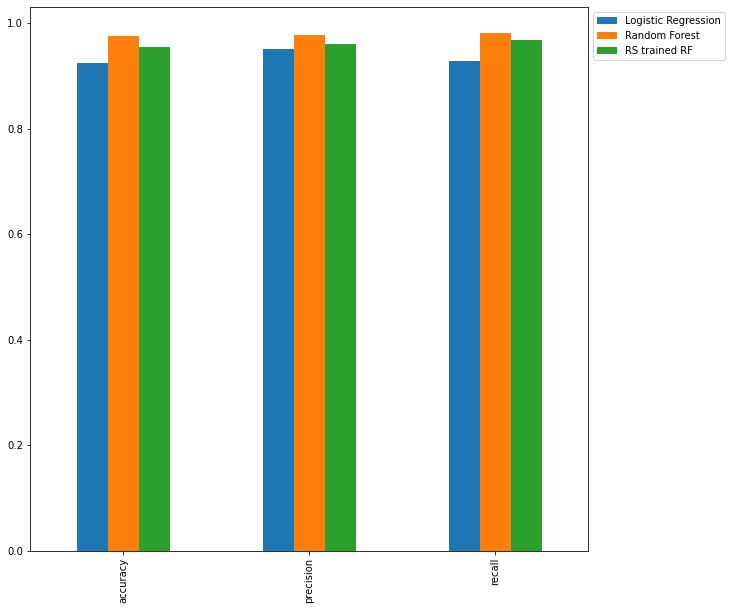

In [ ]:
compare_new_metrics = pd.DataFrame(model_metrics)

compare_new_metrics.plot.bar(figsize=(10, 10)).legend(bbox_to_anchor=(1,1));

# Export the trained model to pickle

In [ ]:
pickle.dump(rf, open('rf_model.pkl', 'wb'))